# Microestructura y Sistemas de Trading
## Technical Analysis

- José Armando Melchor Soto


---

#### Librerias 


In [148]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ta
import optuna

In [149]:
data = pd.read_csv("aapl_5m_train.csv").dropna()
data

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0
...,...,...,...,...,...,...,...,...,...
39573,19787,1672432500,0,2022-12-30 20:35:00,129.020004,129.050003,128.899993,129.039993,773964.0
39574,19788,1672432800,0,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,833767.0
39575,19789,1672433100,0,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,2136910.0
39576,19790,1672433400,0,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,2879267.0


In [150]:
def backtest(data, trial) -> float:
    data = data.copy()


    rsi_window = trial.suggest_int("rsi_window", 5, 50)
    rsi_lower = trial.suggest_int("rsi_lower", 5, 35)
    rsi_upper = trial.suggest_int("rsi_upper", 65, 95)
    stop_loss = trial.suggest_float("stop_loss", 0.01, 0.15)
    take_profit = trial.suggest_float("take_profit", 0.01, 0.15)
    n_shares = trial.suggest_int("n_shares", 50, 500)

    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    historic = data.dropna()
    historic["buy_signal"] = historic.rsi < 20
    historic["sell_signal"] = historic.rsi > 80 #LOS TENEMOS QUE ENCONTRAR

    COM = 0.125 / 100
    SL = stop_loss
    TP = take_profit
    BORROW_RATE = 0.25/100

    cash = 1_000_000



    active_long_positions= []

    portfolio_value = [cash]

    for i, row in historic.iterrows():
        
        # This only works for long positions
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))


        # Close Operations
        for position in active_long_positions.copy():
            if row.Close > position.take_profit or row.Close < position.stop_loss:
                cash += row.Close * position.n_shares * (1 - COM)
                active_long_positions.remove(position)

        # --- BUY
        # Check Signal
        if not row.buy_signal:
            portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

            continue

        # Enough Cash?
        if cash < row.Close * n_shares * (1 + COM):
            portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

            continue
        # Discount Costs
        cash -= row.Close * n_shares * (1 + COM)


        # Save the Operation as active position
        active_long_positions.append(
            Operation(
            time=row.Datetime,
            price=row.Close,
            take_profit=row.Close * (1 + TP),
            stop_loss= row.Close * (1 - SL),
            n_shares=n_shares,
            type = "LONG"
        )
    )

        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

    #añadimos al cash las posiciones que siguen abiertas cuando terminamos las posiciones

    cash += row.Close * len(active_long_positions) *(1 - COM)
    active_position = []

    return (cash / 1_000_000) - 1


In [151]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: backtest(data, trial), n_trials=10)

[I 2025-09-12 07:12:40,314] A new study created in memory with name: no-name-871b48b2-aa3a-449c-8a3f-f09c621419a2
C:\Users\ppmel\AppData\Local\Temp\ipykernel_1524\3214520164.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic["buy_signal"] = historic.rsi < 20
C:\Users\ppmel\AppData\Local\Temp\ipykernel_1524\3214520164.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic["sell_signal"] = historic.rsi > 80 #LOS TENEMOS QUE ENCONTRAR
[I 2025-09-12 07:12:42,438] Trial 0 finished with value: 0

In [152]:
study.best_params

{'rsi_window': 22,
 'rsi_lower': 22,
 'rsi_upper': 84,
 'stop_loss': 0.09623973680042153,
 'take_profit': 0.04268779151306112,
 'n_shares': 485}

In [153]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=20)

In [154]:
dir(rsi_indicator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_fillna',
 '_close',
 '_fillna',
 '_rsi',
 '_run',
 '_true_range',
 '_window',
 'rsi']

In [155]:
data["rsi"] = rsi_indicator.rsi()

In [156]:
historic = data.dropna()
historic["buy_signal"] = historic.rsi < 20
historic["sell_signal"] = historic.rsi > 80

C:\Users\ppmel\AppData\Local\Temp\ipykernel_1524\971527806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic["buy_signal"] = historic.rsi < 20
C:\Users\ppmel\AppData\Local\Temp\ipykernel_1524\971527806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic["sell_signal"] = historic.rsi > 80


In [157]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price: float, n_shares: int) -> float:

    val = cash

    # Add long positions value

    val += len(long_ops) * current_price * n_shares

    # TO DO: Add short positions value

    return val

In [158]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [159]:
COM = 0.125 / 100
SL = 0.05
TP = 0.05
BORROW_RATE = 0.25/100

cash = 1_000_000
n_shares = 50


active_long_positions= []

portfolio_value = [cash]

for i, row in historic.iterrows():
    
    # This only works for long positions
    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))


    # Close Operations
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # --- BUY
    # Check Signal
    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

        continue

    # Enough Cash?
    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

        continue
    # Discount Costs
    cash -= row.Close * n_shares * (1 + COM)


    # Save the Operation as active position
    active_long_positions.append(
        Operation(
        time=row.Datetime,
        price=row.Close,
        take_profit=row.Close * (1 + TP),
        stop_loss= row.Close * (1 - SL),
        n_shares=n_shares,
        type = "LONG"
    )
)

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

#añadimos al cash las posiciones que siguen abiertas cuando terminamos las posiciones

cash += row.Close * len(active_long_positions) *(1 - COM)
active_position = []

In [160]:
cash

1007816.8160896875

In [161]:
active_long_positions

[]

<Axes: >

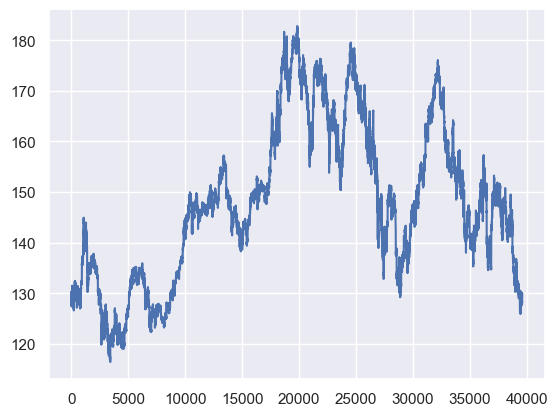

In [162]:
historic.Close.plot()

In [163]:
cash, len(active_long_positions)

(1007816.8160896875, 0)

<Axes: >

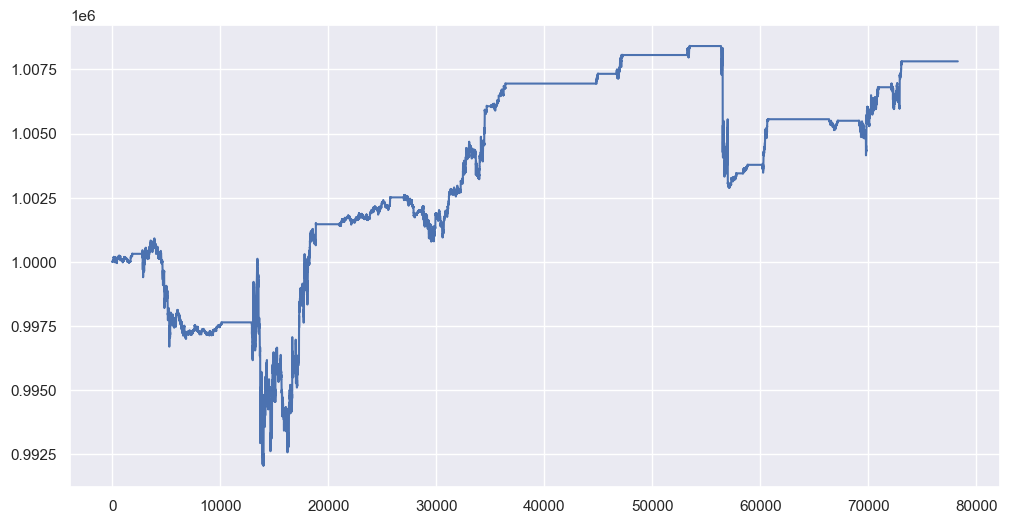

In [164]:
pd.Series(portfolio_value).plot(figsize=(12,6))